# **Exploratory Data Analysis**
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

import scipy.stats as st
from sklearn import preprocessing as pre

In [2]:
RANDOM_STATE = 42

## **2) Recommended exploration tasks**
---

### Motivation:

Our primary objective with this exploratory analysis is to identify the features in our data that best represent our understanding of the [root causes of flight delays](../Research/flight_delay_reasons.md) and in so doing, provide the basis for the **accurate** and **reliable** prediction of commercial flight delays. We aim to develop a sense for how well our feature space captures common flight delay reasons in order to determine which features to select, which additional data to gather, and which features should be re-engineered or excluded.

#### [Suggested considerations](https://github.com/lighthouse-labs/mid-term-project-I/blob/master/exploratory_analysis.ipynb) synopsis:

1. [Test the hypothesis that the arrival delay is from Normal distribution and that mean of the delay is 0. Be careful about the outliers.](#task1)
2. Is average/median monthly delay different during the year? If so, which months have the biggest delays and what could be the reason?
3. Does the weather affect the delay?
4. How are taxi times changing during the day? Does higher traffic lead to longer taxi times?
5. What is the average percentage of delays that exist prior to departure (*i.e.* are arrival delays caused by departure delays)? Are airlines able to lower the delay during the flights?
6. How many states cover 50% of US air traffic?
7. Test the hypothesis that planes fly faster when there is a departure delay.
8. When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?
9. Find the top 10 the bussiest airports. Does the greatest number of flights mean that the majority of passengers went through a given airport? How much traffic do these 10 airports cover?
10. Do bigger delays lead to bigger fuel consumption per passenger?

### 1) Is the arrival delay normally distributed with a mean of 0?<a id='task1'></a>

#### `arr_delay` distribution

In [3]:
flights = pd.read_csv('../Data/files/flights_no_missing.csv')
flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay'],
      dtype='object')

In [4]:
flights['arr_delay'].describe()

count    2.339962e+06
mean     5.466329e+00
std      4.992268e+01
min     -1.290000e+03
25%     -1.500000e+01
50%     -6.000000e+00
75%      8.000000e+00
max      2.692000e+03
Name: arr_delay, dtype: float64

<AxesSubplot:xlabel='arr_delay'>

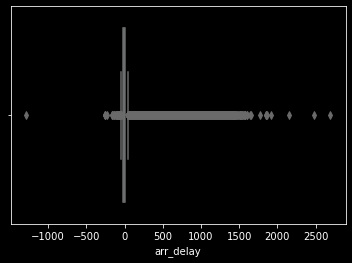

In [5]:
sns.boxplot(x=flights['arr_delay'])

In [6]:
st.normaltest(flights['arr_delay'])

NormaltestResult(statistic=3414284.7469730703, pvalue=0.0)

In [7]:
flights['arr_delay'].shape[0]

2339962

We have strong evidence to reject the null hypothesis that the data is sampled from a normal distribution. Let us attempt a robust [quantile transformation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) to see if we can better normalize the data. [Google](https://developers.google.com/machine-learning/clustering/prepare-data) suggests using ~10x fewer quantiles than the number of observations, so we will attempt that. (Note that this is not a requirement. [Jason Brownlee](https://machinelearningmastery.com/quantile-transforms-for-machine-learning/) found reasonable success using ~2x fewer quantiles than observations, but that was with a much smaller dataset and the number of rows we have here is so large that we should avoid too high of a subsample to prevent the operation from becoming prohibitively computationally expensive for the limited time we have to complete this project.)

In [8]:
quantile_transformer = pre.QuantileTransformer(n_quantiles=250000, subsample=250000, output_distribution='normal', random_state=RANDOM_STATE)

In [9]:
quantile_delay = quantile_transformer.fit_transform(flights['arr_delay'].to_numpy().reshape(-1, 1))

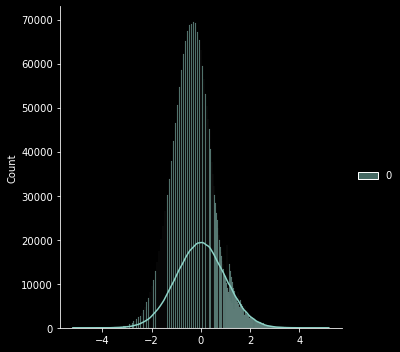

In [10]:
sns.displot(quantile_delay, kde=True)

In [11]:
st.normaltest(quantile_delay)

NormaltestResult(statistic=array([16.40402169]), pvalue=array([0.0002741]))

#### Outlier inspection

A quantile transformation on its own is insufficient to justify the assumption of normality using a reasonable subsample size. We should first deal with outliers. To do so we will compare them on the basis of z score to filter out values with exceedingly anomolous deviations from the mean.

In [12]:
# Return only rows with flights where the z score of the arrival delay is within 3 standard deviations of the mean.
flights_no_arrival_outliers = flights[(np.abs(st.zscore(flights['arr_delay'])) < 3)]

Now let's check the lost data to ensure that we only eliminated outliers and not actual components of a trend in a wide distribution.

In [13]:
percent_retained = flights_no_arrival_outliers.shape[0] / flights.shape[0] * 100
observations_lost = flights.shape[0] - flights_no_arrival_outliers.shape[0]

print(f'{observations_lost} "outliers" were eliminated, retaining {percent_retained} of the original DataFrame.')

37906 "outliers" were eliminated, retaining 98.38005916335393 of the original DataFrame.


Less than 2% of the data were removed by the above operation. Let us test the assumption of normality again now. We should try to include as much data as possible while supporting the null hypothesis that out data was drawn from a normal distribution.

In [14]:
st.normaltest(flights_no_arrival_outliers.arr_delay)

NormaltestResult(statistic=1108764.9326740047, pvalue=0.0)

It appears that the assumption of normality remains invalid. Let us check the distribution of the pruned DataFrame to get a better intuition for why this may be.

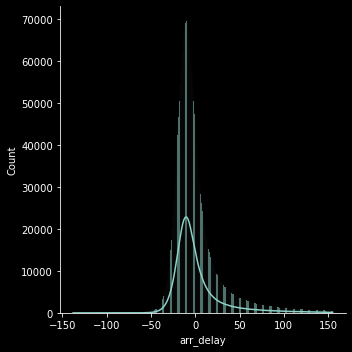

In [15]:
sns.displot(flights_no_arrival_outliers.arr_delay, kde=True)

<AxesSubplot:xlabel='arr_delay'>

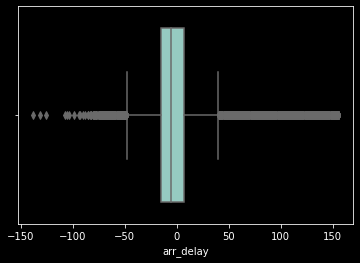

In [16]:
sns.boxplot(x=flights_no_arrival_outliers.arr_delay)

The assumption of normality is most likely violated on the bases that:
1) the right and left tails are asymmetric because more flights are delayed than are early.
2) there are appreciable gaps in the sampled data.  

Let us try applying a quantile transformation on the distribution with outliers removed and see if that helps.

In [17]:
quantile_transformed_arrival_delay_no_outliers = quantile_transformer.fit_transform(
    flights_no_arrival_outliers['arr_delay'].to_numpy().reshape(-1, 1))

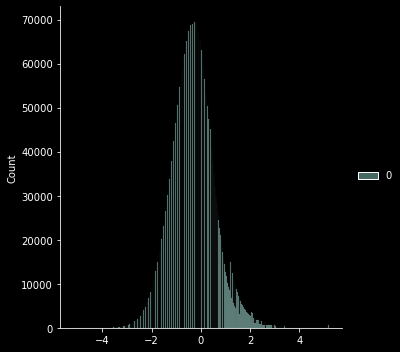

In [18]:
sns.displot(quantile_transformed_arrival_delay_no_outliers)

<AxesSubplot:>

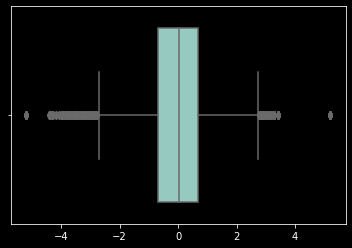

In [19]:
sns.boxplot(x=quantile_transformed_arrival_delay_no_outliers)

In [20]:
st.normaltest(quantile_transformed_arrival_delay_no_outliers)

NormaltestResult(statistic=array([1251.82619391]), pvalue=array([1.47705219e-272]))

It is clear that there is sufficent statistical evidence to reject the null hypothesis that the underlying distribution of the sample from the flights table is normally distributed when outliers are considered to be values 3 or more standard deviations from the mean; however, statistical tests that are robust with respect to the assumption of normality (such as the Student's t-test) may still be applicable.

In [21]:
st.ttest_1samp(flights_no_arrival_outliers['arr_delay'], 0)

Ttest_1sampResult(statistic=56.64040377294951, pvalue=0.0)

In [22]:
st.ttest_1samp(quantile_transformed_arrival_delay_no_outliers, 0)

Ttest_1sampResult(statistic=array([3.07636692]), pvalue=array([0.00209542]))

As we can see above, even using our quantile transformed data with outliers removed provides inadequate support for the null hypothesis that our data is drawn from a normal distribution centered around a mean of 0.